<a href="https://colab.research.google.com/github/rreyes2155/Synthetic_Real_Faces/blob/main/DATA_690_Deep_Learning_Project_EDA_GCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

In [ ]:
# install gcsfuse so we can load our bucket as local file
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1210  100  1210    0     0  55000      0 --:--:-- --:--:-- --:--:-- 55000
OK
72 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.42.4).
0 upgraded, 0 newly installed, 0 to remove and 72 not upgraded.


In [ ]:
# make directory and load our bucket to directory
!mkdir faces
!gcsfuse --implicit-dirs data690deeplearning faces

mkdir: cannot create directory ‘faces’: File exists
I0512 22:18:38.417241 2023/05/12 22:18:38.417197 Start gcsfuse/0.42.4 (Go version go1.19.7) for app "" using mount point: /content/faces


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from skimage import io
import random
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image

# Data Import, Cleaning, and Visualization



In [ ]:
# upload metadata csvs for each dataset
celeb_real = pd.read_csv('faces/celebahq_metadata.csv')
celeb_fake_lama = pd.read_csv('faces/lama_metadata.csv')
celeb_fake_mat = pd.read_csv('faces/mat_metadata.csv')

## Clean CelebAHQ (real)

In [ ]:
celeb_real.head()

,filename,image_path,target,category
0,img008621.jpg,celebahq/data1024x1024/img008621.jpg,0,NaN
1,img010767.jpg,celebahq/data1024x1024/img010767.jpg,0,NaN
2,img005709.jpg,celebahq/data1024x1024/img005709.jpg,0,NaN
3,img009051.jpg,celebahq/data1024x1024/img009051.jpg,0,NaN
4,img006376.jpg,celebahq/data1024x1024/img006376.jpg,0,NaN


In [ ]:
print(celeb_real.shape,'\n',celeb_real['target'].unique(), celeb_real['category'].unique())

(30000, 4) 
 [0] [nan]


In [ ]:
# keep only image path and make target
celeb_real = 'faces/' + celeb_real[['image_path']].copy()
celeb_real['target'] = 'real'

In [ ]:
celeb_real.head()

,image_path,target
0,faces/celebahq/data1024x1024/img008621.jpg,real
1,faces/celebahq/data1024x1024/img010767.jpg,real
2,faces/celebahq/data1024x1024/img005709.jpg,real
3,faces/celebahq/data1024x1024/img009051.jpg,real
4,faces/celebahq/data1024x1024/img006376.jpg,real


In [ ]:
# not all files were transferred, so check and remove image paths that weren't transferred
missing_celeb_real = []
for img in celeb_real['image_path']:
    if os.path.exists(img) is False:
        missing_celeb_real.append(img)

In [ ]:
len(missing_celeb_real)

20724

In [ ]:
# removed files that were not transferred
celeb_real = celeb_real[~celeb_real['image_path'].isin(missing_celeb_real)]

In [ ]:
# reset index
celeb_real.reset_index(inplace = True, drop = True)

In [ ]:
celeb_real.shape

(9276, 2)

In [ ]:
# save cleaned df to new csv
celeb_real.to_csv('faces/celebahq_metadata_cleaned.csv', index = False)

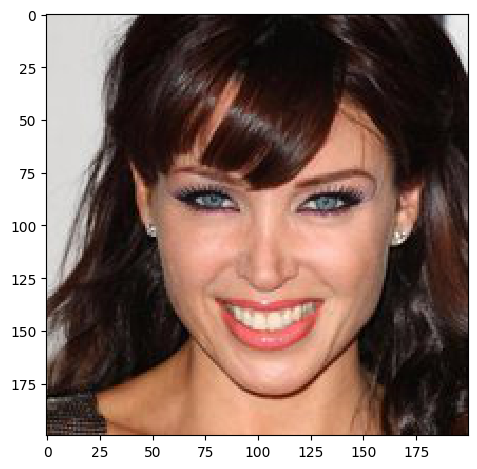

In [ ]:
real_rand_img = io.imread(celeb_real['image_path'].iloc[random.randint(0,len(celeb_real))])
io.imshow(real_rand_img)

## Clean Lama (real)

In [ ]:
celeb_fake_lama.head()

,filename,image_path,target,category
0,img001833.jpg,lama/lama-dataset/celeb/lamaDeep/img001833.jpg,6,celeb
1,img002314.jpg,lama/lama-dataset/celeb/lamaDeep/img002314.jpg,6,celeb
2,img001780.jpg,lama/lama-dataset/celeb/lamaDeep/img001780.jpg,6,celeb
3,img000546.jpg,lama/lama-dataset/celeb/lamaDeep/img000546.jpg,6,celeb
4,img002932.jpg,lama/lama-dataset/celeb/lamaDeep/img002932.jpg,6,celeb


In [ ]:
print(celeb_fake_lama.shape,'\n',celeb_fake_lama['target'].unique(), celeb_fake_lama['category'].unique())

(10449, 4) 
 [6] ['celeb']


In [ ]:
celeb_fake_lama = celeb_fake_lama[celeb_fake_lama['category']=='celeb']

In [ ]:
print(celeb_fake_lama.shape,'\n',celeb_fake_lama['target'].unique(), celeb_fake_lama['category'].unique())

(10449, 4) 
 [6] ['celeb']


In [ ]:
# keep only image path and make target, also extract what type it is.
temp = celeb_fake_lama['image_path'].str.split('/', expand = True)[3]
celeb_fake_lama = 'faces/' + celeb_fake_lama[['image_path']].copy()
celeb_fake_lama['type'] = temp
celeb_fake_lama['target'] = 'fake'

In [ ]:
celeb_fake_lama.head()

,image_path,type,target
0,faces/lama/lama-dataset/celeb/lamaDeep/img0018...,lamaDeep,fake
1,faces/lama/lama-dataset/celeb/lamaDeep/img0023...,lamaDeep,fake
2,faces/lama/lama-dataset/celeb/lamaDeep/img0017...,lamaDeep,fake
3,faces/lama/lama-dataset/celeb/lamaDeep/img0005...,lamaDeep,fake
4,faces/lama/lama-dataset/celeb/lamaDeep/img0029...,lamaDeep,fake


In [ ]:
celeb_fake_lama['type'].unique()

array(['lamaDeep', 'lamaDilated', 'lamaFourier'], dtype=object)

In [ ]:
# not all files were transferred, so check and remove image paths that weren't transferred
missing_lama = []
for img in celeb_fake_lama['image_path']:
    if os.path.exists(img) is False:
        missing_lama.append(img)

In [ ]:
len(missing_lama)

1665

In [ ]:
# removed files that were not transferred
celeb_fake_lama = celeb_fake_lama[~celeb_fake_lama['image_path'].isin(missing_lama)]

In [ ]:
celeb_fake_lama.shape

(8784, 3)

In [ ]:
celeb_fake_lama['type'].value_counts()

lamaDeep       3483
lamaDilated    3483
lamaFourier    1818
Name: type, dtype: int64

There are 3 different datasets for celebs with 3,483 images in two and 1818 in one. They are identical but created with different techniques. Lets create different dataframes for them seperately.

### Seperate Lama types

In [ ]:
# create seperate dfs for each type
celeb_fake_lama_deep = celeb_fake_lama[celeb_fake_lama['type'] == 'lamaDeep'].copy()
celeb_fake_lama_dialated = celeb_fake_lama[celeb_fake_lama['type'] == 'lamaDilated'].copy()
celeb_fake_lama_fourier = celeb_fake_lama[celeb_fake_lama['type'] == 'lamaFourier'].copy()

In [ ]:
print(celeb_fake_lama_deep.shape,celeb_fake_lama_deep['type'].unique(),celeb_fake_lama_deep['target'].unique())
print(celeb_fake_lama_dialated.shape,celeb_fake_lama_dialated['type'].unique(),celeb_fake_lama_dialated['target'].unique())
print(celeb_fake_lama_fourier.shape,celeb_fake_lama_fourier['type'].unique(),celeb_fake_lama_fourier['target'].unique())

(3483, 3) ['lamaDeep'] ['fake']
(3483, 3) ['lamaDilated'] ['fake']
(1818, 3) ['lamaFourier'] ['fake']


In [ ]:
# drop type column since we have serparated types in to different dfs
celeb_fake_lama_deep.drop(columns=['type'], inplace = True)
celeb_fake_lama_dialated.drop(columns=['type'], inplace = True)
celeb_fake_lama_fourier.drop(columns=['type'], inplace = True)

celeb_fake_lama.drop(columns=['type'], inplace = True)

In [ ]:
# save cleaned dfs seperately to new csvs
celeb_fake_lama.to_csv('faces/lama_all_metadata_cleaned.csv', index = False)
celeb_fake_lama_deep.to_csv('faces/lama_deep_metadata_cleaned.csv', index = False)
celeb_fake_lama_dialated.to_csv('faces/lama_dialated_metadata_cleaned.csv', index = False)
celeb_fake_lama_fourier.to_csv('faces/lama_fourier_metadata_cleaned.csv', index = False)

In [ ]:
celeb_fake_lama_deep.head()

,image_path,target
0,faces/lama/lama-dataset/celeb/lamaDeep/img0018...,fake
1,faces/lama/lama-dataset/celeb/lamaDeep/img0023...,fake
2,faces/lama/lama-dataset/celeb/lamaDeep/img0017...,fake
3,faces/lama/lama-dataset/celeb/lamaDeep/img0005...,fake
4,faces/lama/lama-dataset/celeb/lamaDeep/img0029...,fake


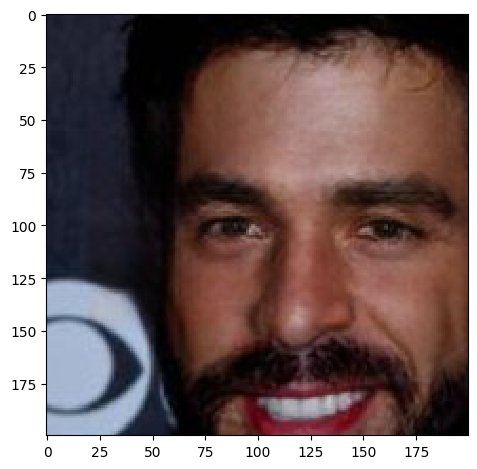

In [ ]:
lama_rand_img = io.imread(celeb_fake_lama['image_path'].iloc[random.randint(0,len(celeb_fake_lama))])
io.imshow(lama_rand_img)

## Clean mat (fake)

In [ ]:
celeb_fake_mat.head()

,filename,image_path,target,category
0,img024200.jpg,mat/celebahq/img024200.jpg,6,celebahq
1,img001790.jpg,mat/celebahq/img001790.jpg,6,celebahq
2,img002921.jpg,mat/celebahq/img002921.jpg,6,celebahq
3,img017797.jpg,mat/celebahq/img017797.jpg,6,celebahq
4,img015752.jpg,mat/celebahq/img015752.jpg,6,celebahq


In [ ]:
print(celeb_fake_mat.shape,'\n',celeb_fake_mat['target'].unique(), celeb_fake_mat['category'].unique())

(60000, 4) 
 [6] ['celebahq' 'landscape']


In [ ]:
celeb_fake_mat = celeb_fake_mat[celeb_fake_mat['category']=='celebahq']

In [ ]:
print(celeb_fake_mat.shape,'\n',celeb_fake_mat['target'].unique(), celeb_fake_mat['category'].unique())

(30000, 4) 
 [6] ['celebahq']


In [ ]:
# keep only image path and make target
celeb_fake_mat = 'faces/' + celeb_fake_mat[['image_path']].copy()
celeb_fake_mat['target'] = 'fake'

In [ ]:
celeb_fake_mat.head()

,image_path,target
0,faces/mat/celebahq/img024200.jpg,fake
1,faces/mat/celebahq/img001790.jpg,fake
2,faces/mat/celebahq/img002921.jpg,fake
3,faces/mat/celebahq/img017797.jpg,fake
4,faces/mat/celebahq/img015752.jpg,fake


In [ ]:
# not all files were transferred, so check and remove image paths that weren't transferred
missing_mat = []
for img in celeb_fake_mat['image_path']:
    if os.path.exists(img) is False:
        missing_mat.append(img)

In [ ]:
len(missing_mat)

22363

In [ ]:
# removed files that were not transferred
celeb_fake_mat = celeb_fake_mat[~celeb_fake_mat['image_path'].isin(missing_mat)]

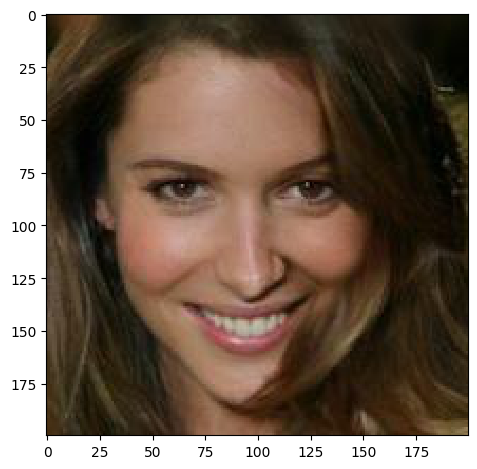

In [ ]:
mat_rand_img = io.imread(celeb_fake_mat['image_path'].iloc[random.randint(0,len(celeb_fake_mat))])
io.imshow(mat_rand_img)

In [ ]:
celeb_fake_mat.shape

(7637, 2)

In [ ]:
celeb_fake_mat.to_csv('faces/mat_metadata_cleaned.csv', index = False)

Now that we have cleaned our dataframes and saved them, lets load them.

## Load Cleaned DataFrames

In [ ]:
# upload cleaned metadata csvs for each dataset
real = pd.read_csv('faces/celebahq_metadata_cleaned.csv')
lama_all = pd.read_csv('faces/lama_all_metadata_cleaned.csv')
mat = pd.read_csv('faces/mat_metadata_cleaned.csv')

# We may not use them but lets load the seperated lama datasets in case we want to try.
lama_deep = pd.read_csv('faces/lama_deep_metadata_cleaned.csv')
lama_dialated = pd.read_csv('faces/lama_dialated_metadata_cleaned.csv')
lama_fourier = pd.read_csv('faces/lama_fourier_metadata_cleaned.csv')

In [ ]:
lama_all.head()

,image_path,target
0,faces/lama/lama-dataset/celeb/lamaDeep/img0018...,fake
1,faces/lama/lama-dataset/celeb/lamaDeep/img0023...,fake
2,faces/lama/lama-dataset/celeb/lamaDeep/img0017...,fake
3,faces/lama/lama-dataset/celeb/lamaDeep/img0005...,fake
4,faces/lama/lama-dataset/celeb/lamaDeep/img0029...,fake


## Visualize Data

In [ ]:
# seperate lists to visulize
all_data_list = [[real, lama_all, mat], ['real', 'lama_all', 'mat']]
lama_data_list = [[lama_deep, lama_dialated, lama_fourier], ['lama_deep', 'lama_dialated', 'lama_fourier']]

In [ ]:
# data visualization function
def plot_lengths(frame_list, title):
    counts = []
    for df in frame_list[0]:
        counts.append(len(df))

    counts_df = pd.DataFrame(list(zip(frame_list[1], counts)), columns = ['DataFrame', 'Number of Samples'])
    display(counts_df)
    
    plt.bar(frame_list[1], counts)
    plt.xlabel('DATASET')
    plt.ylabel('NUMBER OF SAMPLES')
    plt.title(title)
    plt.tight_layout()
    plt.show()

,DataFrame,Number of Samples
0,real,9276
1,lama_all,8784
2,mat,7637


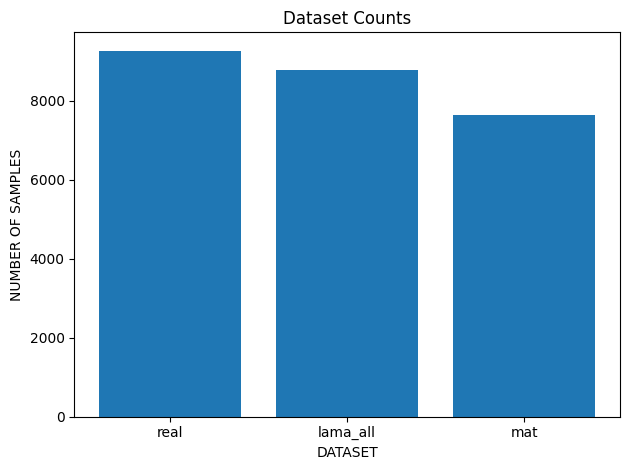

In [ ]:
# plot all data
plot_lengths(all_data_list, 'Dataset Counts')

,DataFrame,Number of Samples
0,lama_deep,3483
1,lama_dialated,3483
2,lama_fourier,1818


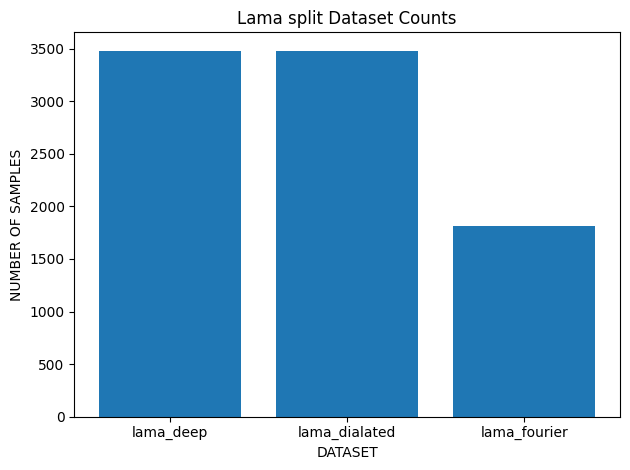

In [ ]:
# plot lama dataset by type
plot_lengths(lama_data_list, 'Lama split Dataset Counts')

## Combine data and create train/testsplit

In [ ]:
# function to combine datasets and create train/test

# accepts a list of the number of samples you want from each dataset
# in this order [real, lama_all, 'mat', 'deep', 'dialated', 'fourier']

def make_test_split(nums, test_portion = 0.2, rs = 3):
    # check we don't pull from lama_all and any of the lama types datasets
    if nums[1] > 0 and (nums[3] > 0 or nums[4] > 0 or nums[5] > 0):
        return null

    # sample each dataset
    a = real.sample(n = nums[0], random_state = rs, ignore_index = True)
    if nums[1] != 0:
        b = lama_all.sample(n = nums[1], random_state = rs, ignore_index = True)
    c = mat.sample(n = nums[2], random_state = rs, ignore_index = True)
    if nums[1] == 0:
        d = lama_deep.sample(n = nums[3], random_state = rs, ignore_index = True)
        e = lama_dialated.sample(n = nums[4], random_state = rs, ignore_index = True)
        f = lama_fourier.sample(n = nums[5], random_state = rs, ignore_index = True)

    # create train/test splits for each dataset
    train_a, test_a = train_test_split(a, test_size = test_portion, random_state = rs)
    if nums[1] != 0:
        train_b, test_b = train_test_split(b, test_size = test_portion, random_state = rs)
    train_c, test_c = train_test_split(c, test_size = test_portion, random_state = rs)
    if nums[1] == 0:
        train_d, test_d = train_test_split(d, test_size = test_portion, random_state = rs)
        train_e, test_e = train_test_split(e, test_size = test_portion, random_state = rs)
        train_f, test_f = train_test_split(f, test_size = test_portion, random_state = rs)

    # list of frames to concat
    if nums[1] != 0:        
        train_frames = [train_a, train_b, train_c]
        test_frames = [test_a, test_b, test_c]
    if nums[1] == 0:        
        train_frames = [train_a, train_c, train_d, train_e, train_f]
        test_frames = [test_a, test_c, test_d, test_e, test_f]

    # concat train/test dfs
    train = pd.concat(train_frames, ignore_index = True)
    test = pd.concat(test_frames, ignore_index = True)

    # shuffle data
    train_shuff = train.sample(frac=1).reset_index(drop=True)
    test_shuff = test.sample(frac=1).reset_index(drop=True)
    
    return train_shuff, test_shuff

In [ ]:
# create train/test data

# [real, lama_all, 'mat', 'deep', 'dialated', 'fourier']
sample_sizes = [500, 250, 250, 0, 0, 0]

train_1000, test_1000 = make_test_split(sample_sizes)

In [ ]:
train_1000.head()

,image_path,target
0,faces/celebahq/data1024x1024/img009515.jpg,real
1,faces/celebahq/data1024x1024/img008295.jpg,real
2,faces/mat/celebahq/img019654.jpg,fake
3,faces/mat/celebahq/img018100.jpg,fake
4,faces/celebahq/data1024x1024/img000303.jpg,real


In [ ]:
test_1000.head()

,image_path,target
0,faces/lama/lama-dataset/celeb/lamaDeep/img0032...,fake
1,faces/celebahq/data1024x1024/img012209.jpg,real
2,faces/celebahq/data1024x1024/img029978.jpg,real
3,faces/celebahq/data1024x1024/img009007.jpg,real
4,faces/lama/lama-dataset/celeb/lamaFourier/img0...,fake


In [ ]:
print(train_1000.shape, test_1000.shape)

(800, 2) (200, 2)


In [ ]:
train_1000['target'].value_counts()

real    400
fake    400
Name: target, dtype: int64

In [ ]:
test_1000['target'].value_counts()

fake    100
real    100
Name: target, dtype: int64